In [5]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import math
import os
import numpy as np

In [6]:
BatchNorm = nn.BatchNorm2d

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3,
                               stride=stride, padding=dilation,
                               bias=False, dilation=dilation)
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=dilation,
                               bias=False, dilation=dilation)
        self.bn2 = BatchNorm(planes)
        self.stride = stride

    def forward(self, x, residual=None):
        if residual is None:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, residual):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, 1,
            stride=1, bias=False, padding=(kernel_size - 1) // 2)
        self.bn = BatchNorm(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.residual = residual

    def forward(self, *x):
        children = x
        x = self.conv(torch.cat(x, 1))
        x = self.bn(x)
        if self.residual:
            x += children[0]
        x = self.relu(x)

        return x

In [9]:
class Tree(nn.Module):
    def __init__(self, levels, block, in_channels, out_channels, stride=1,
                 level_root=False, root_dim=0, root_kernel_size=1,
                 dilation=1, root_residual=False):
        super(Tree, self).__init__()
        if root_dim == 0:
            root_dim = 2 * out_channels
        if level_root:
            root_dim += in_channels
        if levels == 1:
            self.tree1 = block(in_channels, out_channels, stride,
                               dilation=dilation)
            self.tree2 = block(out_channels, out_channels, 1,
                               dilation=dilation)
        else:
            self.tree1 = Tree(levels - 1, block, in_channels, out_channels,
                              stride, root_dim=0,
                              root_kernel_size=root_kernel_size,
                              dilation=dilation, root_residual=root_residual)
            self.tree2 = Tree(levels - 1, block, out_channels, out_channels,
                              root_dim=root_dim + out_channels,
                              root_kernel_size=root_kernel_size,
                              dilation=dilation, root_residual=root_residual)
        if levels == 1:
            self.root = Root(root_dim, out_channels, root_kernel_size,
                             root_residual)
        self.level_root = level_root
        self.root_dim = root_dim
        self.downsample = None
        self.project = None
        self.levels = levels
        if stride > 1:
            self.downsample = nn.MaxPool2d(stride, stride=stride)
        if in_channels != out_channels:
            self.project = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=1, bias=False),
                BatchNorm(out_channels)
            )

    def forward(self, x, residual=None, children=None):
        children = [] if children is None else children
        bottom = self.downsample(x) if self.downsample else x
        residual = self.project(bottom) if self.project else bottom
        if self.level_root:
            children.append(bottom)
        x1 = self.tree1(x, residual)
        if self.levels == 1:
            x2 = self.tree2(x1)
            x = self.root(x2, x1, *children)
        else:
            children.append(x1)
            x = self.tree2(x1, children=children)
        return x


>> DLA BACKBONE

In [10]:
import torch.utils.model_zoo as model_zoo


class DLA(nn.Module):
    def __init__(self, levels, channels, num_classes=1000,
                 block=BasicBlock, residual_root=False, return_levels=False,
                 pool_size=7, linear_root=False):
        super(DLA, self).__init__()
        self.channels = channels
        self.return_levels = return_levels
        self.num_classes = num_classes
        self.base_layer = nn.Sequential(
            nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                      padding=3, bias=False),
            BatchNorm(channels[0]),
            nn.ReLU(inplace=True))
        self.level0 = self._make_conv_level(
            channels[0], channels[0], levels[0])
        self.level1 = self._make_conv_level(
            channels[0], channels[1], levels[1], stride=2)
        self.level2 = Tree(levels[2], block, channels[1], channels[2], 2,
                           level_root=False,
                           root_residual=residual_root)
        self.level3 = Tree(levels[3], block, channels[2], channels[3], 2,
                           level_root=True, root_residual=residual_root)
        self.level4 = Tree(levels[4], block, channels[3], channels[4], 2,
                           level_root=True, root_residual=residual_root)
        self.level5 = Tree(levels[5], block, channels[4], channels[5], 2,
                           level_root=True, root_residual=residual_root)

        self.avgpool = nn.AvgPool2d(pool_size)
        self.fc = nn.Conv2d(channels[-1], num_classes, kernel_size=1,
                            stride=1, padding=0, bias=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_level(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.MaxPool2d(stride, stride=stride),
                nn.Conv2d(inplanes, planes,
                          kernel_size=1, stride=1, bias=False),
                BatchNorm(planes),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample=downsample))
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_conv_level(self, inplanes, planes, convs, stride=1, dilation=1):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(inplanes, planes, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                BatchNorm(planes),
                nn.ReLU(inplace=True)])
            inplanes = planes
        return nn.Sequential(*modules)

    def forward(self, x):
        y = []
        x = self.base_layer(x)
        for i in range(6):
            x = getattr(self, 'level{}'.format(i))(x)
            y.append(x)
        if self.return_levels:
            return y
        else:
            x = self.avgpool(x)
            x = self.fc(x)
            x = x.view(x.size(0), -1)

            return x

    def load_pretrained_model(self, data='imagenet', name='dla34', hash='ba72cf86'):
        fc = self.fc
        path = '/Users/strom/Desktop/dla34-ba72cf86.pth'
        model_weights = torch.load(path)
        num_classes = len(model_weights[list(model_weights.keys())[-1]])
        self.fc = nn.Conv2d(
            self.channels[-1], num_classes,
            kernel_size=1, stride=1, padding=0, bias=True)
        self.load_state_dict(model_weights)
        self.fc = fc

In [11]:
def dla34(pretrained=False, **kwargs):  # DLA-34
    model = DLA([1, 1, 1, 2, 2, 1],
                [16, 32, 64, 128, 256, 512],
                block=BasicBlock, **kwargs)
    if pretrained:
        model.load_pretrained_model(data='imagenet', name='dla34', hash='ba72cf86')
    return model

In [12]:
net = dla34(pretrained=True)
print(net)

DLA(
  (base_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level0): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level2): Tree(
    (tree1): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kern

In [13]:
from torchviz import make_dot

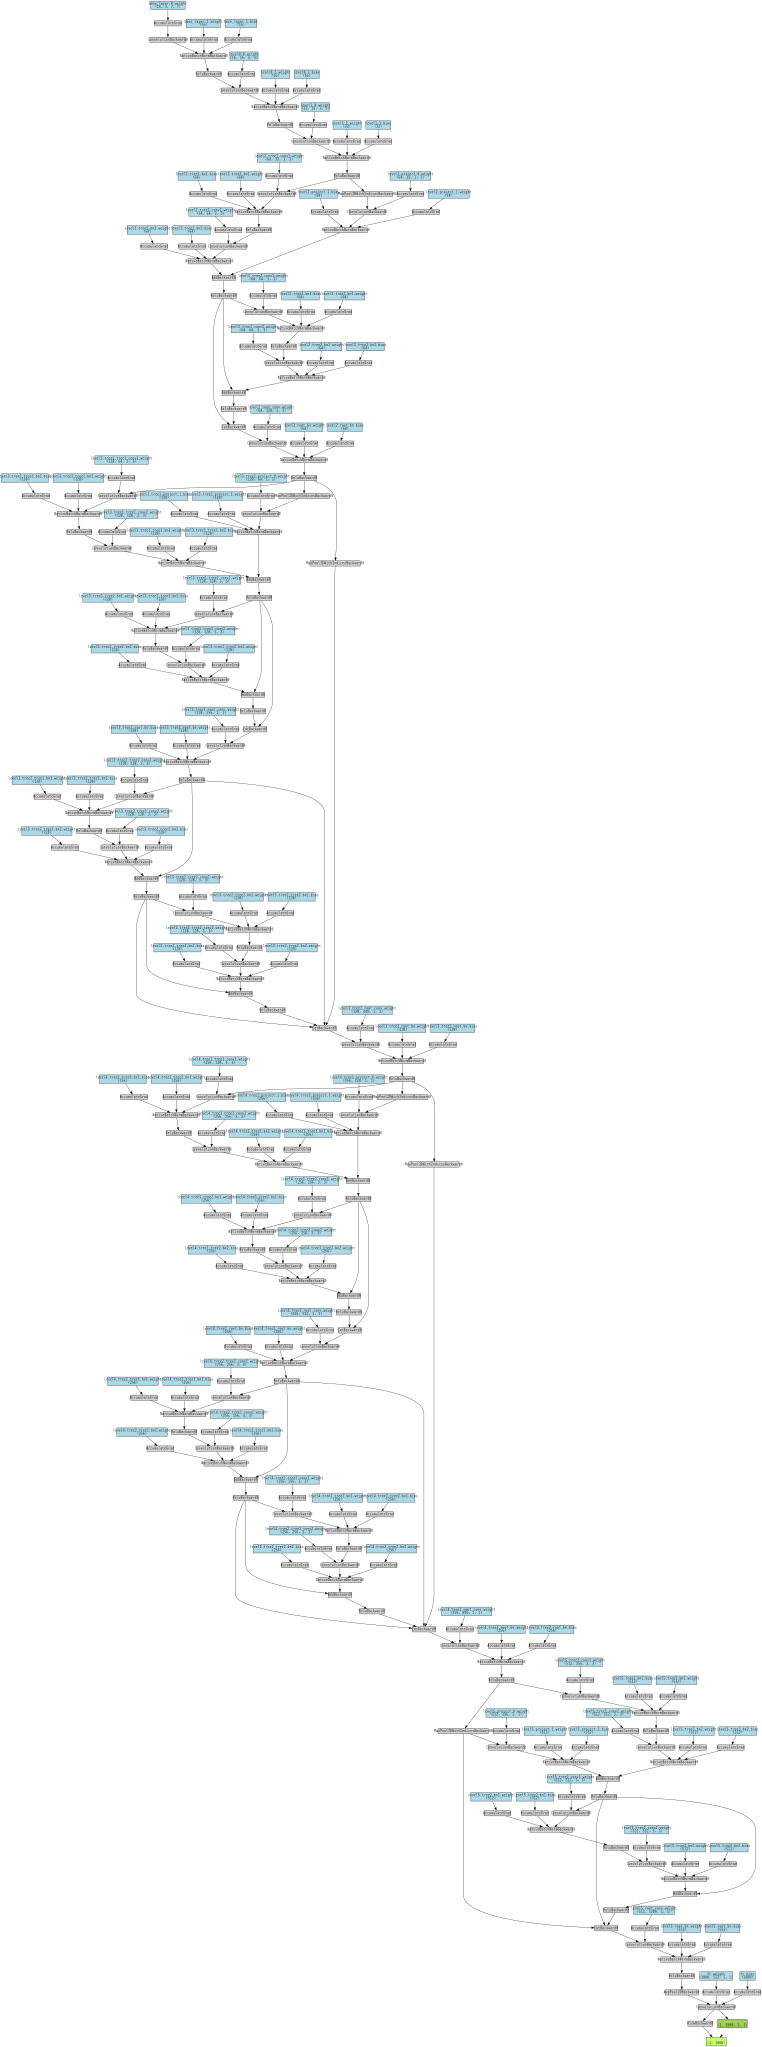

In [14]:
make_dot(net(torch.randn(1, 3, 224, 224)), params=dict(net.named_parameters()))

In [15]:
import os
from graphviz import Digraph

os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\GraphvizX.XX\bin"  # replace with your Graphviz bin folder path
dot = Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')
dot.render('test-output/round-table.gv', view=True)

'test-output\\round-table.gv.pdf'

>> DLA UP HEAD

In [16]:
def fill_up_weights(up):
    w = up.weight.data
    f = math.ceil(w.size(2) / 2)
    c = (2 * f - 1 - f % 2) / (2. * f)
    for i in range(w.size(2)):
        for j in range(w.size(3)):
            w[0, 0, i, j] = \
                (1 - math.fabs(i / f - c)) * (1 - math.fabs(j / f - c))
    for c in range(1, w.size(0)):
        w[c, 0, :, :] = w[0, 0, :, :]

In [17]:
class Conv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernal_szie=3, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes,
                              out_planes,
                              kernel_size=kernal_szie,
                              stride=stride,
                              padding=kernal_szie//2,
                              bias=bias)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [18]:
class IDAUp(nn.Module):
    '''
    input: features map of different layers
    output: up-sampled features
    '''
    def __init__(self, in_channels_list, up_factors_list, out_channels):
        super(IDAUp, self).__init__()
        self.in_channels_list = in_channels_list
        self.out_channels = out_channels

        for i in range(1, len(in_channels_list)):
            in_channels = in_channels_list[i]
            up_factors = int(up_factors_list[i])

            proj = Conv2d(in_channels, out_channels, kernal_szie=3, stride=1, bias=False)
            node = Conv2d(out_channels*2, out_channels, kernal_szie=3, stride=1, bias=False)
            up = nn.ConvTranspose2d(in_channels=out_channels,
                                    out_channels=out_channels,
                                    kernel_size=up_factors * 2,
                                    stride=up_factors,
                                    padding=up_factors // 2,
                                    output_padding=0,
                                    groups=out_channels,
                                    bias=False)
            fill_up_weights(up)

            setattr(self, 'proj_' + str(i), proj)
            setattr(self, 'up_' + str(i), up)
            setattr(self, 'node_' + str(i), node)


        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, layers):
        assert len(self.in_channels_list) == len(layers), \
            '{} vs {} layers'.format(len(self.in_channels_list), len(layers))

        for i in range(1, len(layers)):
            upsample = getattr(self, 'up_' + str(i))
            project = getattr(self, 'proj_' + str(i))
            node = getattr(self, 'node_' + str(i))

            layers[i] = upsample(project(layers[i]))
            layers[i] = node(torch.cat([layers[i-1], layers[i]], 1))

        return layers

In [19]:
class DLAUp(nn.Module):
    def __init__(self, in_channels_list, scales_list=(1, 2, 4, 8, 16)):
        super(DLAUp, self).__init__()
        scales_list = np.array(scales_list, dtype=int)

        for i in range(len(in_channels_list) - 1):
            j = -i - 2
            setattr(self, 'ida_{}'.format(i), IDAUp(in_channels_list=in_channels_list[j:],
                                                    up_factors_list=scales_list[j:] // scales_list[j],
                                                    out_channels=in_channels_list[j]))
            scales_list[j + 1:] = scales_list[j]
            in_channels_list[j + 1:] = [in_channels_list[j] for _ in in_channels_list[j + 1:]]

    def forward(self, layers):
        layers = list(layers)
        assert len(layers) > 1
        for i in range(len(layers) - 1):
            ida = getattr(self, 'ida_{}'.format(i))
            layers[-i - 2:] = ida(layers[-i - 2:])
        return layers[-1]

In [20]:
backbone = dla34(return_levels=True)
input = torch.randn(2, 3, 64, 64)
features = backbone(input)
print('input data shape:', input.shape)
print('numbers of feature maps generated by DLA backbone:', len(features))
print('feature maps generated by DLA backbone:')
for i in range(len(features)):
    print(features[i].shape)

channels = backbone.channels
start_level = int(np.log2(4))
scales = [2 ** i for i in range(len(channels[start_level:]))]
print('channels list of DLA features:', channels)
print('start level of features-up aggratation:', start_level)
print('upsumapling factors of features', scales)

dlaup = DLAUp(in_channels_list=channels[start_level:], scales_list=scales)
features_up = dlaup(features[start_level:])
print('shape of upsampled feature maps', features_up.shape)

input data shape: torch.Size([2, 3, 64, 64])
numbers of feature maps generated by DLA backbone: 6
feature maps generated by DLA backbone:
torch.Size([2, 16, 64, 64])
torch.Size([2, 32, 32, 32])
torch.Size([2, 64, 16, 16])
torch.Size([2, 128, 8, 8])
torch.Size([2, 256, 4, 4])
torch.Size([2, 512, 2, 2])
channels list of DLA features: [16, 32, 64, 128, 256, 512]
start level of features-up aggratation: 2
upsumapling factors of features [1, 2, 4, 8]
shape of upsampled feature maps torch.Size([2, 64, 16, 16])


>> TOTAL CENTER NET MODEL

In [21]:
class CenterNet3D(nn.Module):
    def __init__(self, backbone='dla34', neck='DLAUp', num_class=3, downsample=4):
        """
        CenterNet for monocular 3D object detection.
        :param backbone: the backbone of pipeline, such as dla34.
        :param neck: the necks of detection, such as dla_up.
        :param downsample: the ratio of down sample. [4, 8, 16, 32]
        :param head_conv: the channels of convolution in head. default: 256
        """
        assert downsample in [4, 8, 16, 32]
        super().__init__()

        self.heads = {'heatmap': num_class, 'offset_2d': 2, 'size_2d' :2, 'depth': 2, 'offset_3d': 2, 'size_3d':3, 'heading': 24}
        self.backbone = dla34(pretrained=True, return_levels=True)
        channels = self.backbone.channels  # channels list for feature maps generated by backbone
        self.first_level = int(np.log2(downsample))
        scales = [2 ** i for i in range(len(channels[self.first_level:]))]
        self.neck = DLAUp(channels[self.first_level:], scales_list=scales)   # feature fusion [such as DLAup, FPN]

        # initialize the head of pipeline, according to heads setting.
        for head in self.heads.keys():
            output_channels = self.heads[head]
            fc = nn.Sequential(
                nn.Conv2d(channels[self.first_level], 256, kernel_size=3, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, output_channels, kernel_size=1, stride=1, padding=0, bias=True))

            # initialization
            if 'heatmap' in head:
                fc[-1].bias.data.fill_(-2.19)
            else:
                self.fill_fc_weights(fc)

            self.__setattr__(head, fc)


    def forward(self, input):
        feat = self.backbone(input)
        feat = self.neck(feat[self.first_level:])

        ret = {}
        for head in self.heads:
            ret[head] = self.__getattr__(head)(feat)

        return ret


    def fill_fc_weights(self, layers):
        for m in layers.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)





In [22]:
model = CenterNet3D(backbone='dla34')
print(net)

input = torch.randn(4, 3, 384, 1280)
print(input.shape, input.dtype)
output = model(input)
print(output.keys())

DLA(
  (base_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level0): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (level2): Tree(
    (tree1): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kern

In [25]:
#make_dot(output['heatmap'], params=dict(model.named_parameters()))

>>check device

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
model.to(device)

CenterNet3D(
  (backbone): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): Tree(
      (tree1): BasicBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

>>LOAD WEIGHTS

In [19]:
def load_checkpoint(model, optimizer, logger=None):
    print("==> Loading from checkpoint ")
    path = '/Users/strom/Documents/GitHub/monodle/experiments/example/checkpoints/checkpoint_epoch_140.pth'
    checkpoint = torch.load(path, device)
    if model is not None and checkpoint['model_state'] is not None:
        model.load_state_dict(checkpoint['model_state'])
    if optimizer is not None and checkpoint['optimizer_state'] is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state'])
    logger.info("==> Done")

In [20]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.00125, weight_decay= 0.00001)

In [21]:
print("==> Loading from checkpoint ")
path = '/Users/strom/Documents/GitHub/monodle/experiments/example/checkpoints/checkpoint_epoch_140.pth'
checkpoint = torch.load(path, device)
if model is not None and checkpoint['model_state'] is not None:
    model.load_state_dict(checkpoint['model_state'])

==> Loading from checkpoint 


>>IMPORT FOR DATALOADER

In [22]:
import numpy as np
import cv2

################  Object3D  ##################

def get_objects_from_label(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    objects = [Object3d(line) for line in lines]
    return objects


class Object3d(object):
    def __init__(self, line):
        label = line.strip().split(' ')
        self.src = line
        self.cls_type = label[0]
        self.trucation = float(label[1])
        self.occlusion = float(label[2])  # 0:fully visible 1:partly occluded 2:largely occluded 3:unknown
        self.alpha = float(label[3])
        self.box2d = np.array((float(label[4]), float(label[5]), float(label[6]), float(label[7])), dtype=np.float32)
        self.h = float(label[8])
        self.w = float(label[9])
        self.l = float(label[10])
        self.pos = np.array((float(label[11]), float(label[12]), float(label[13])), dtype=np.float32)
        self.dis_to_cam = np.linalg.norm(self.pos)
        self.ry = float(label[14])
        self.score = float(label[15]) if label.__len__() == 16 else -1.0
        self.level_str = None
        self.level = self.get_obj_level()


    def get_obj_level(self):
        height = float(self.box2d[3]) - float(self.box2d[1]) + 1

        if self.trucation == -1:
            self.level_str = 'DontCare'
            return 0

        if height >= 40 and self.trucation <= 0.15 and self.occlusion <= 0:
            self.level_str = 'Easy'
            return 1  # Easy
        elif height >= 25 and self.trucation <= 0.3 and self.occlusion <= 1:
            self.level_str = 'Moderate'
            return 2  # Moderate
        elif height >= 25 and self.trucation <= 0.5 and self.occlusion <= 2:
            self.level_str = 'Hard'
            return 3  # Hard
        else:
            self.level_str = 'UnKnown'
            return 4


    def generate_corners3d(self):
        """
        generate corners3d representation for this object
        :return corners_3d: (8, 3) corners of box3d in camera coord
        """
        l, h, w = self.l, self.h, self.w
        x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
        y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
        z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

        R = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                      [0, 1, 0],
                      [-np.sin(self.ry), 0, np.cos(self.ry)]])
        corners3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)
        corners3d = np.dot(R, corners3d).T
        corners3d = corners3d + self.pos
        return corners3d


    def to_bev_box2d(self, oblique=True, voxel_size=0.1):
        """
        :param bev_shape: (2) for bev shape (h, w), => (y_max, x_max) in image
        :param voxel_size: float, 0.1m
        :param oblique:
        :return: box2d (4, 2)/ (4) in image coordinate
        """
        if oblique:
            corners3d = self.generate_corners3d()
            xz_corners = corners3d[0:4, [0, 2]]
            box2d = np.zeros((4, 2), dtype=np.int32)
            box2d[:, 0] = ((xz_corners[:, 0] - Object3d.MIN_XZ[0]) / voxel_size).astype(np.int32)
            box2d[:, 1] = Object3d.BEV_SHAPE[0] - 1 - ((xz_corners[:, 1] - Object3d.MIN_XZ[1]) / voxel_size).astype(np.int32)
            box2d[:, 0] = np.clip(box2d[:, 0], 0, Object3d.BEV_SHAPE[1])
            box2d[:, 1] = np.clip(box2d[:, 1], 0, Object3d.BEV_SHAPE[0])
        else:
            box2d = np.zeros(4, dtype=np.int32)
            # discrete_center = np.floor((self.pos / voxel_size)).astype(np.int32)
            cu = np.floor((self.pos[0] - Object3d.MIN_XZ[0]) / voxel_size).astype(np.int32)
            cv = Object3d.BEV_SHAPE[0] - 1 - ((self.pos[2] - Object3d.MIN_XZ[1]) / voxel_size).astype(np.int32)
            half_l, half_w = int(self.l / voxel_size / 2), int(self.w / voxel_size / 2)
            box2d[0], box2d[1] = cu - half_l, cv - half_w
            box2d[2], box2d[3] = cu + half_l, cv + half_w

        return box2d


    def to_str(self):
        print_str = '%s %.3f %.3f %.3f box2d: %s hwl: [%.3f %.3f %.3f] pos: %s ry: %.3f' \
                     % (self.cls_type, self.trucation, self.occlusion, self.alpha, self.box2d, self.h, self.w, self.l,
                        self.pos, self.ry)
        return print_str


    def to_kitti_format(self):
        kitti_str = '%s %.2f %d %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f' \
                    % (self.cls_type, self.trucation, int(self.occlusion), self.alpha, self.box2d[0], self.box2d[1],
                       self.box2d[2], self.box2d[3], self.h, self.w, self.l, self.pos[0], self.pos[1], self.pos[2],
                       self.ry)
        return kitti_str



###################  calibration  ###################

def get_calib_from_file(calib_file):
    with open(calib_file) as f:
        lines = f.readlines()

    obj = lines[2].strip().split(' ')[1:]
    P2 = np.array(obj, dtype=np.float32)
    obj = lines[3].strip().split(' ')[1:]
    P3 = np.array(obj, dtype=np.float32)
    obj = lines[4].strip().split(' ')[1:]
    R0 = np.array(obj, dtype=np.float32)
    obj = lines[5].strip().split(' ')[1:]
    Tr_velo_to_cam = np.array(obj, dtype=np.float32)

    return {'P2': P2.reshape(3, 4),
            'P3': P3.reshape(3, 4),
            'R0': R0.reshape(3, 3),
            'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}


class Calibration(object):
    def __init__(self, calib_file):
        if isinstance(calib_file, str):
            calib = get_calib_from_file(calib_file)
        else:
            calib = calib_file

        self.P2 = calib['P2']  # 3 x 4
        self.R0 = calib['R0']  # 3 x 3
        self.V2C = calib['Tr_velo2cam']  # 3 x 4
        self.C2V = self.inverse_rigid_trans(self.V2C)

        # Camera intrinsics and extrinsics
        self.cu = self.P2[0, 2]
        self.cv = self.P2[1, 2]
        self.fu = self.P2[0, 0]
        self.fv = self.P2[1, 1]
        self.tx = self.P2[0, 3] / (-self.fu)
        self.ty = self.P2[1, 3] / (-self.fv)

    def cart_to_hom(self, pts):
        """
        :param pts: (N, 3 or 2)
        :return pts_hom: (N, 4 or 3)
        """
        pts_hom = np.hstack((pts, np.ones((pts.shape[0], 1), dtype=np.float32)))
        return pts_hom

    def lidar_to_rect(self, pts_lidar):
        """
        :param pts_lidar: (N, 3)
        :return pts_rect: (N, 3)
        """
        pts_lidar_hom = self.cart_to_hom(pts_lidar)
        pts_rect = np.dot(pts_lidar_hom, np.dot(self.V2C.T, self.R0.T))
        # pts_rect = reduce(np.dot, (pts_lidar_hom, self.V2C.T, self.R0.T))
        return pts_rect

    def rect_to_lidar(self, pts_rect):
        pts_ref = np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_rect)))
        pts_ref = self.cart_to_hom(pts_ref)  # nx4
        return np.dot(pts_ref, np.transpose(self.C2V))

    def rect_to_img(self, pts_rect):
        """
        :param pts_rect: (N, 3)
        :return pts_img: (N, 2)
        """
        pts_rect_hom = self.cart_to_hom(pts_rect)
        pts_2d_hom = np.dot(pts_rect_hom, self.P2.T)
        pts_img = (pts_2d_hom[:, 0:2].T / pts_rect_hom[:, 2]).T  # (N, 2)
        pts_rect_depth = pts_2d_hom[:, 2] - self.P2.T[3, 2]  # depth in rect camera coord
        return pts_img, pts_rect_depth

    def lidar_to_img(self, pts_lidar):
        """
        :param pts_lidar: (N, 3)
        :return pts_img: (N, 2)
        """
        pts_rect = self.lidar_to_rect(pts_lidar)
        pts_img, pts_depth = self.rect_to_img(pts_rect)
        return pts_img, pts_depth

    def img_to_rect(self, u, v, depth_rect):
        """
        :param u: (N)
        :param v: (N)
        :param depth_rect: (N)
        :return:
        """
        x = ((u - self.cu) * depth_rect) / self.fu + self.tx
        y = ((v - self.cv) * depth_rect) / self.fv + self.ty
        pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
        return pts_rect

    def depthmap_to_rect(self, depth_map):
        """
        :param depth_map: (H, W), depth_map
        :return:
        """
        x_range = np.arange(0, depth_map.shape[1])
        y_range = np.arange(0, depth_map.shape[0])
        x_idxs, y_idxs = np.meshgrid(x_range, y_range)
        x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)
        depth = depth_map[y_idxs, x_idxs]
        pts_rect = self.img_to_rect(x_idxs, y_idxs, depth)
        return pts_rect, x_idxs, y_idxs

    def corners3d_to_img_boxes(self, corners3d):
        """
        :param corners3d: (N, 8, 3) corners in rect coordinate
        :return: boxes: (None, 4) [x1, y1, x2, y2] in rgb coordinate
        :return: boxes_corner: (None, 8) [xi, yi] in rgb coordinate
        """
        sample_num = corners3d.shape[0]
        corners3d_hom = np.concatenate((corners3d, np.ones((sample_num, 8, 1))), axis=2)  # (N, 8, 4)

        img_pts = np.matmul(corners3d_hom, self.P2.T)  # (N, 8, 3)

        x, y = img_pts[:, :, 0] / img_pts[:, :, 2], img_pts[:, :, 1] / img_pts[:, :, 2]
        x1, y1 = np.min(x, axis=1), np.min(y, axis=1)
        x2, y2 = np.max(x, axis=1), np.max(y, axis=1)

        boxes = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
        boxes_corner = np.concatenate((x.reshape(-1, 8, 1), y.reshape(-1, 8, 1)), axis=2)

        return boxes, boxes_corner

    def camera_dis_to_rect(self, u, v, d):
        """
        Can only process valid u, v, d, which means u, v can not beyond the image shape, reprojection error 0.02
        :param u: (N)
        :param v: (N)
        :param d: (N), the distance between camera and 3d points, d^2 = x^2 + y^2 + z^2
        :return:
        """
        assert self.fu == self.fv, '%.8f != %.8f' % (self.fu, self.fv)
        fd = np.sqrt((u - self.cu) ** 2 + (v - self.cv) ** 2 + self.fu ** 2)
        x = ((u - self.cu) * d) / fd + self.tx
        y = ((v - self.cv) * d) / fd + self.ty
        z = np.sqrt(d ** 2 - x ** 2 - y ** 2)
        pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), axis=1)
        return pts_rect

    def inverse_rigid_trans(self, Tr):
        ''' Inverse a rigid body transform matrix (3x4 as [R|t])
            [R'|-R't; 0|1]
        '''
        inv_Tr = np.zeros_like(Tr)  # 3x4
        inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
        inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
        return inv_Tr

    def alpha2ry(self, alpha, u):
        """
        Get rotation_y by alpha + theta - 180
        alpha : Observation angle of object, ranging [-pi..pi]
        x : Object center x to the camera center (x-W/2), in pixels
        rotation_y : Rotation ry around Y-axis in camera coordinates [-pi..pi]
        """
        ry = alpha + np.arctan2(u - self.cu, self.fu)

        if ry > np.pi:
            ry -= 2 * np.pi
        if ry < -np.pi:
            ry += 2 * np.pi

        return ry

    def ry2alpha(self, ry, u):
        alpha = ry - np.arctan2(u - self.cu, self.fu)

        if alpha > np.pi:
            alpha -= 2 * np.pi
        if alpha < -np.pi:
            alpha += 2 * np.pi

        return alpha



###################  affine trainsform  ###################

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
        trans_inv = cv2.getAffineTransform(np.float32(dst), np.float32(src))
        return trans, trans_inv
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
    return trans


def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

In [23]:
def angle2class(angle):
    ''' Convert continuous angle to discrete class and residual. '''
    angle = angle % (2 * np.pi)
    assert (angle >= 0 and angle <= 2 * np.pi)
    angle_per_class = 2 * np.pi / float(num_heading_bin)
    shifted_angle = (angle + angle_per_class / 2) % (2 * np.pi)
    class_id = int(shifted_angle / angle_per_class)
    residual_angle = shifted_angle - (class_id * angle_per_class + angle_per_class / 2)
    return class_id, residual_angle


def class2angle(cls, residual, to_label_format=False):
    ''' Inverse function to angle2class. '''
    angle_per_class = 2 * np.pi / float(num_heading_bin)
    angle_center = cls * angle_per_class
    angle = angle_center + residual
    if to_label_format and angle > np.pi:
        angle = angle - 2 * np.pi
    return angle


def gaussian_radius(bbox_size, min_overlap=0.7):
    height, width = bbox_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h


def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
    x, y = int(center[0]), int(center[1])
    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap


def draw_projected_box3d(image, corners3d, color=(255, 255, 255), thickness=1):
    ''' Draw 3d bounding box in image
    input:
        image: RGB image
        corners3d: (8,3) array of vertices (in image plane) for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7

    '''

    corners3d = corners3d.astype(np.int32)
    for k in range(0, 4):
        i, j = k, (k + 1) % 4
        cv2.line(image, (corners3d[i, 0], corners3d[i, 1]), (corners3d[j, 0], corners3d[j, 1]), color, thickness, lineType=cv2.LINE_AA)
        i, j = k + 4, (k + 1) % 4 + 4
        cv2.line(image, (corners3d[i, 0], corners3d[i, 1]), (corners3d[j, 0], corners3d[j, 1]), color, thickness, lineType=cv2.LINE_AA)
        i, j = k, k + 4
        cv2.line(image, (corners3d[i, 0], corners3d[i, 1]), (corners3d[j, 0], corners3d[j, 1]), color, thickness, lineType=cv2.LINE_AA)
    return image

In [24]:
from lib.datasets.kitti.kitti_eval_python.eval import get_official_eval_result
from lib.datasets.kitti.kitti_eval_python.eval import get_distance_eval_result
import lib.datasets.kitti.kitti_eval_python.kitti_common as kitti

>>DATALOADER

In [25]:
import torch.utils.data as data
class KITTI_Dataset(data.Dataset):
    def __init__(self, split, cfg):
        # basic configuration
        self.root_dir = cfg.get('root_dir', '../../data/KITTI')
        self.split = split
        self.num_classes = 3
        self.max_objs = 50
        self.class_name = ['Pedestrian', 'Car', 'Cyclist']
        self.cls2id = {'Pedestrian': 0, 'Car': 1, 'Cyclist': 2}
        self.resolution = np.array([1280, 384])  # W * H
        self.use_3d_center = cfg.get('use_3d_center', True)
        self.writelist = cfg.get('writelist', ['Car'])
        # anno: use src annotations as GT, proj: use projected 2d bboxes as GT
        self.bbox2d_type = cfg.get('bbox2d_type', 'anno')
        assert self.bbox2d_type in ['anno', 'proj']
        self.meanshape = cfg.get('meanshape', False)
        self.class_merging = cfg.get('class_merging', False)
        self.use_dontcare = cfg.get('use_dontcare', False)

        if self.class_merging:
            self.writelist.extend(['Van', 'Truck'])
        if self.use_dontcare:
            self.writelist.extend(['DontCare'])


        # data split loading
        assert self.split in ['train', 'val', 'trainval', 'test']
        self.split_file = os.path.join(self.root_dir, 'ImageSets', self.split + '.txt')
        self.idx_list = [x.strip() for x in open(self.split_file).readlines()]

        # path configuration
        self.data_dir = os.path.join(self.root_dir, 'object', 'testing' if split == 'test' else 'training')
        self.image_dir = os.path.join(self.data_dir, 'image_2')
        self.depth_dir = os.path.join(self.data_dir, 'depth')
        self.calib_dir = os.path.join(self.data_dir, 'calib')
        self.label_dir = os.path.join(self.data_dir, 'label_2')

        # data augmentation configuration
        self.data_augmentation = True if split in ['train', 'trainval'] else False
        self.random_flip = cfg.get('random_flip', 0.5)
        self.random_crop = cfg.get('random_crop', 0.5)
        self.scale = cfg.get('scale', 0.4)
        self.shift = cfg.get('shift', 0.1)

        # statistics
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        self.cls_mean_size = np.array([[1.76255119, 0.66068622, 0.84422524],
                                       [1.52563191, 1.62856739, 3.52588311],
                                       [1.73698127, 0.59706367, 1.76282397]], dtype=np.float32)  # H*W*L
        if not self.meanshape:
            self.cls_mean_size = np.zeros_like(self.cls_mean_size, dtype=np.float32)

        # others
        self.downsample = 4



    def get_image(self, idx):
        img_file = os.path.join(self.image_dir, '%06d.png' % idx)
        assert os.path.exists(img_file)
        return Image.open(img_file)


    def get_label(self, idx):
        label_file = os.path.join(self.label_dir, '%06d.txt' % idx)
        assert os.path.exists(label_file)
        return get_objects_from_label(label_file)


    def get_calib(self, idx):
        calib_file = os.path.join(self.calib_dir, '%06d.txt' % idx)
        assert os.path.exists(calib_file)
        return Calibration(calib_file)

    def eval(self, results_dir, logger):
        logger.info("==> Loading detections and GTs...")
        img_ids = [int(id) for id in self.idx_list]
        dt_annos = kitti.get_label_annos(results_dir)
        gt_annos = kitti.get_label_annos(self.label_dir, img_ids)

        test_id = {'Car': 0, 'Pedestrian':1, 'Cyclist': 2}

        logger.info('==> Evaluating (official) ...')
        for category in self.writelist:
            results_str, results_dict = get_official_eval_result(gt_annos, dt_annos, test_id[category])
            logger.info(results_str)


    def __len__(self):
        return self.idx_list.__len__()


    def __getitem__(self, item):
        #  ============================   get inputs   ===========================
        index = int(self.idx_list[item])  # index mapping, get real data id
        # image loading
        img = self.get_image(index)
        img_size = np.array(img.size)
        features_size = self.resolution // self.downsample    # W * H

        # data augmentation for image
        center = np.array(img_size) / 2
        aug_scale, crop_size = 1.0, img_size
        random_crop_flag, random_flip_flag = False, False
        if self.data_augmentation:
            if np.random.random() < self.random_flip:
                random_flip_flag = True
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

            if np.random.random() < self.random_crop:
                random_crop_flag = True
                aug_scale = np.clip(np.random.randn() * self.scale + 1, 1 - self.scale, 1 + self.scale)
                crop_size = img_size * aug_scale
                center[0] += img_size[0] * np.clip(np.random.randn() * self.shift, -2 * self.shift, 2 * self.shift)
                center[1] += img_size[1] * np.clip(np.random.randn() * self.shift, -2 * self.shift, 2 * self.shift)

        # add affine transformation for 2d images.
        trans, trans_inv = get_affine_transform(center, crop_size, 0, self.resolution, inv=1)
        img = img.transform(tuple(self.resolution.tolist()),
                            method=Image.AFFINE,
                            data=tuple(trans_inv.reshape(-1).tolist()),
                            resample=Image.BILINEAR)
        # image encoding
        img = np.array(img).astype(np.float32) / 255.0
        img = (img - self.mean) / self.std
        img = img.transpose(2, 0, 1)  # C * H * W

        info = {'img_id': index,
                'img_size': img_size,
                'bbox_downsample_ratio': img_size/features_size}

        if self.split == 'test':
            return img, img, info   # img / placeholder(fake label) / info


        #  ============================   get labels   ==============================
        objects = self.get_label(index)
        calib = self.get_calib(index)

        # computed 3d projected box
        if self.bbox2d_type == 'proj':
            for object in objects:
                object.box2d_proj = np.array(calib.corners3d_to_img_boxes(object.generate_corners3d()[None, :])[0][0], dtype=np.float32)
                object.box2d = object.box2d_proj.copy()

        # data augmentation for labels
        if random_flip_flag:
            for object in objects:
                [x1, _, x2, _] = object.box2d
                object.box2d[0],  object.box2d[2] = img_size[0] - x2, img_size[0] - x1
                object.alpha = np.pi - object.alpha
                object.ry = np.pi - object.ry
                if object.alpha > np.pi:  object.alpha -= 2 * np.pi  # check range
                if object.alpha < -np.pi: object.alpha += 2 * np.pi
                if object.ry > np.pi:  object.ry -= 2 * np.pi
                if object.ry < -np.pi: object.ry += 2 * np.pi


        # labels encoding
        heatmap = np.zeros((self.num_classes, features_size[1], features_size[0]), dtype=np.float32) # C * H * W
        size_2d = np.zeros((self.max_objs, 2), dtype=np.float32)
        offset_2d = np.zeros((self.max_objs, 2), dtype=np.float32)
        depth = np.zeros((self.max_objs, 1), dtype=np.float32)
        heading_bin = np.zeros((self.max_objs, 1), dtype=np.int64)
        heading_res = np.zeros((self.max_objs, 1), dtype=np.float32)
        src_size_3d = np.zeros((self.max_objs, 3), dtype=np.float32)
        size_3d = np.zeros((self.max_objs, 3), dtype=np.float32)
        offset_3d = np.zeros((self.max_objs, 2), dtype=np.float32)
        indices = np.zeros((self.max_objs), dtype=np.int64)
        mask_2d = np.zeros((self.max_objs), dtype=np.uint8)
        mask_3d = np.zeros((self.max_objs), dtype=np.uint8)
        object_num = len(objects) if len(objects) < self.max_objs else self.max_objs
        for i in range(object_num):
            # filter objects by writelist
            if objects[i].cls_type not in self.writelist:
                continue

            # filter inappropriate samples
            if objects[i].level_str == 'UnKnown' or objects[i].pos[-1] < 2:
                continue

            # ignore the samples beyond the threshold [hard encoding]
            threshold = 65
            if objects[i].pos[-1] > threshold:
                continue

            # process 2d bbox & get 2d center
            bbox_2d = objects[i].box2d.copy()

            # add affine transformation for 2d boxes.
            bbox_2d[:2] = affine_transform(bbox_2d[:2], trans)
            bbox_2d[2:] = affine_transform(bbox_2d[2:], trans)
            # modify the 2d bbox according to pre-compute downsample ratio
            bbox_2d[:] /= self.downsample

            # process 3d bbox & get 3d center
            center_2d = np.array([(bbox_2d[0] + bbox_2d[2]) / 2, (bbox_2d[1] + bbox_2d[3]) / 2], dtype=np.float32)  # W * H
            center_3d = objects[i].pos + [0, -objects[i].h / 2, 0]  # real 3D center in 3D space
            center_3d = center_3d.reshape(-1, 3)  # shape adjustment (N, 3)
            center_3d, _ = calib.rect_to_img(center_3d)  # project 3D center to image plane
            center_3d = center_3d[0]  # shape adjustment
            if random_flip_flag:  # random flip for center3d
                center_3d[0] = img_size[0] - center_3d[0]
            center_3d = affine_transform(center_3d.reshape(-1), trans)
            center_3d /= self.downsample

            # generate the center of gaussian heatmap [optional: 3d center or 2d center]
            center_heatmap = center_3d.astype(np.int32) if self.use_3d_center else center_2d.astype(np.int32)
            if center_heatmap[0] < 0 or center_heatmap[0] >= features_size[0]: continue
            if center_heatmap[1] < 0 or center_heatmap[1] >= features_size[1]: continue

            # generate the radius of gaussian heatmap
            w, h = bbox_2d[2] - bbox_2d[0], bbox_2d[3] - bbox_2d[1]
            radius = gaussian_radius((w, h))
            radius = max(0, int(radius))

            if objects[i].cls_type in ['Van', 'Truck', 'DontCare']:
                draw_umich_gaussian(heatmap[1], center_heatmap, radius)
                continue

            cls_id = self.cls2id[objects[i].cls_type]
            draw_umich_gaussian(heatmap[cls_id], center_heatmap, radius)

            # encoding 2d/3d offset & 2d size
            indices[i] = center_heatmap[1] * features_size[0] + center_heatmap[0]
            offset_2d[i] = center_2d - center_heatmap
            size_2d[i] = 1. * w, 1. * h

            # encoding depth
            depth[i] = objects[i].pos[-1] * aug_scale

            # encoding heading angle
            heading_angle = objects[i].alpha
            heading_bin[i], heading_res[i] = angle2class(heading_angle)

            # encoding 3d offset & size_3d
            offset_3d[i] = center_3d - center_heatmap
            src_size_3d[i] = np.array([objects[i].h, objects[i].w, objects[i].l], dtype=np.float32)
            mean_size = self.cls_mean_size[self.cls2id[objects[i].cls_type]]
            size_3d[i] = src_size_3d[i] - mean_size

            mask_2d[i] = 1
            mask_3d[i] = 0 if random_crop_flag else 1


        # collect return data
        inputs = img
        targets = {'depth': depth,
                   'size_2d': size_2d,
                   'heatmap': heatmap,
                   'offset_2d': offset_2d,
                   'indices': indices,
                   'size_3d': size_3d,
                   'src_size_3d': src_size_3d,
                   'offset_3d': offset_3d,
                   'heading_bin': heading_bin,
                   'heading_res': heading_res,
                   'mask_2d': mask_2d,
                   'mask_3d': mask_3d}
        info = {'img_id': index,
                'img_size': img_size,
                'bbox_downsample_ratio': img_size/features_size}
        return inputs, targets, info

In [ ]:
test_set = KITTI_Dataset(split='val')
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=test_set,
                             batch_size=cfg['batch_size'],
                             num_workers=workers,
                             worker_init_fn=my_worker_init_fn,
                             shuffle=False,
                             pin_memory=False,
                             drop_last=False)

In [32]:
from torch.utils.data import DataLoader
from PIL import Image
num_heading_bin = 12  # hyper param

cfg = {'root_dir': 'data/KITTI',
        'random_flip':0.0, 'random_crop':1.0, 'scale':0.8, 'shift':0.1, 'use_dontcare': False,
        'class_merging': False, 'writelist':['Pedestrian', 'Car', 'Cyclist'], 'use_3d_center':False}
dataset = KITTI_Dataset('train', cfg)
dataloader = DataLoader(dataset=dataset, batch_size=1)
print(dataset.writelist)

for batch_idx, (inputs, targets, info) in enumerate(dataloader):
    # test image
    img = inputs[0].numpy().transpose(1, 2, 0)
    img = (img * dataset.std + dataset.mean) * 255
    img = Image.fromarray(img.astype(np.uint8))
    img.show()
    # print(targets['size_3d'][0][0])

    # test heatmap
    heatmap = targets['heatmap'][0]  # image id
    heatmap = Image.fromarray(heatmap[0].numpy() * 255)  # cats id
    heatmap.show()

    break


# print ground truth fisrt
objects = dataset.get_label(0)
for object in objects:
    print(object.to_kitti_format())

['Pedestrian', 'Car', 'Cyclist']


C:\Users\strom\AppData\Local\Temp\ipykernel_27304\2336974785.py:122: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  method=Image.AFFINE,
C:\Users\strom\AppData\Local\Temp\ipykernel_27304\2336974785.py:124: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resample=Image.BILINEAR)


Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


>>INFERENCE

In [33]:
############### auxiliary function ############

num_heading_bin = 12  # hyper param

def class2angle(cls, residual, to_label_format=False):
    ''' Inverse function to angle2class. '''
    angle_per_class = 2 * np.pi / float(num_heading_bin)
    angle_center = cls * angle_per_class
    angle = angle_center + residual
    if to_label_format and angle > np.pi:
        angle = angle - 2 * np.pi
    return angle

def _nms(heatmap, kernel=3):
    padding = (kernel - 1) // 2
    heatmapmax = nn.functional.max_pool2d(heatmap, (kernel, kernel), stride=1, padding=padding)
    keep = (heatmapmax == heatmap).float()
    return heatmap * keep


def _topk(heatmap, K=50):
    batch, cat, height, width = heatmap.size()

    # batch * cls_ids * 50
    topk_scores, topk_inds = torch.topk(heatmap.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (topk_inds / width).int().float()
    topk_xs = (topk_inds % width).int().float()

    # batch * cls_ids * 50
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_cls_ids = (topk_ind / K).int()
    topk_inds = _gather_feat(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_cls_ids, topk_xs, topk_ys


def _gather_feat(feat, ind, mask=None):
    '''
    Args:
        feat: tensor shaped in B * (H*W) * C
        ind:  tensor shaped in B * K (default: 50)
        mask: tensor shaped in B * K (default: 50)

    Returns: tensor shaped in B * K or B * sum(mask)
    '''
    dim  = feat.size(2)  # get channel dim
    ind  = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)  # B*len(ind) --> B*len(ind)*1 --> B*len(ind)*C
    feat = feat.gather(1, ind)  # B*(HW)*C ---> B*K*C
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)  # B*50 ---> B*K*1 --> B*K*C
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat


def _transpose_and_gather_feat(feat, ind):
    '''
    Args:
        feat: feature maps shaped in B * C * H * W
        ind: indices tensor shaped in B * K
    Returns:
    '''
    feat = feat.permute(0, 2, 3, 1).contiguous()   # B * C * H * W ---> B * H * W * C
    feat = feat.view(feat.size(0), -1, feat.size(3))   # B * H * W * C ---> B * (H*W) * C
    feat = _gather_feat(feat, ind)     # B * len(ind) * C
    return feat


def get_heading_angle(heading):
    heading_bin, heading_res = heading[0:12], heading[12:24]
    cls = np.argmax(heading_bin)
    res = heading_res[cls]
    return class2angle(cls, res, to_label_format=True)

In [34]:
def extract_dets_from_outputs(outputs, K=50):
    # get src outputs
    heatmap = outputs['heatmap']
    heading = outputs['heading']
    depth = outputs['depth'][:, 0:1, :, :]
    sigma = outputs['depth'][:, 1:2, :, :]
    size_3d = outputs['size_3d']
    offset_3d = outputs['offset_3d']
    size_2d = outputs['size_2d']
    offset_2d = outputs['offset_2d']

    heatmap= torch.clamp(heatmap.sigmoid_(), min=1e-4, max=1 - 1e-4)
    depth = 1. / (depth.sigmoid() + 1e-6) - 1.
    sigma = torch.exp(-sigma)

    batch, channel, height, width = heatmap.size() # get shape

    # perform nms on heatmaps
    heatmap = _nms(heatmap)
    scores, inds, cls_ids, xs, ys = _topk(heatmap, K=K)

    offset_2d = _transpose_and_gather_feat(offset_2d, inds)
    offset_2d = offset_2d.view(batch, K, 2)
    xs2d = xs.view(batch, K, 1) + offset_2d[:, :, 0:1]
    ys2d = ys.view(batch, K, 1) + offset_2d[:, :, 1:2]

    offset_3d = _transpose_and_gather_feat(offset_3d, inds)
    offset_3d = offset_3d.view(batch, K, 2)
    xs3d = xs.view(batch, K, 1) + offset_3d[:, :, 0:1]
    ys3d = ys.view(batch, K, 1) + offset_3d[:, :, 1:2]

    heading = _transpose_and_gather_feat(heading, inds)
    heading = heading.view(batch, K, 24)
    depth = _transpose_and_gather_feat(depth, inds)
    depth = depth.view(batch, K, 1)
    sigma = _transpose_and_gather_feat(sigma, inds)
    sigma = sigma.view(batch, K, 1)
    size_3d = _transpose_and_gather_feat(size_3d, inds)
    size_3d = size_3d.view(batch, K, 3)
    cls_ids = cls_ids.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)

    # check shape
    xs2d = xs2d.view(batch, K, 1)
    ys2d = ys2d.view(batch, K, 1)
    xs3d = xs3d.view(batch, K, 1)
    ys3d = ys3d.view(batch, K, 1)

    size_2d = _transpose_and_gather_feat(size_2d, inds)
    size_2d = size_2d.view(batch, K, 2)

    detections = torch.cat([cls_ids, scores, xs2d, ys2d, size_2d, depth, heading, size_3d, xs3d, ys3d, sigma], dim=2)

    return detections

In [35]:
def decode_detections(dets, info, calibs, cls_mean_size, threshold):
    '''
    NOTE: THIS IS A NUMPY FUNCTION
    input: dets, numpy array, shape in [batch x max_dets x dim]
    input: img_info, dict, necessary information of input images
    input: calibs, corresponding calibs for the input batch
    output:
    '''
    results = {}
    for i in range(dets.shape[0]):  # batch
        preds = []
        for j in range(dets.shape[1]):  # max_dets
            cls_id = int(dets[i, j, 0])
            score = dets[i, j, 1]
            if score < threshold:
                continue

            # 2d bboxs decoding
            x = dets[i, j, 2] * info['bbox_downsample_ratio'][i][0]
            y = dets[i, j, 3] * info['bbox_downsample_ratio'][i][1]
            w = dets[i, j, 4] * info['bbox_downsample_ratio'][i][0]
            h = dets[i, j, 5] * info['bbox_downsample_ratio'][i][1]
            bbox = [x-w/2, y-h/2, x+w/2, y+h/2]

            # 3d bboxs decoding
            # depth decoding
            depth = dets[i, j, 6]

            # dimensions decoding
            dimensions = dets[i, j, 31:34]
            dimensions += cls_mean_size[int(cls_id)]

            # positions decoding
            x3d = dets[i, j, 34] * info['bbox_downsample_ratio'][i][0]
            y3d = dets[i, j, 35] * info['bbox_downsample_ratio'][i][1]
            locations = calibs[i].img_to_rect(x3d, y3d, depth).reshape(-1)
            locations[1] += dimensions[0] / 2

            # heading angle decoding
            alpha = get_heading_angle(dets[i, j, 7:31])
            ry = calibs[i].alpha2ry(alpha, x3d)

            score = score * dets[i, j, -1]

            ##### generate 2d bbox using 3d bbox
            # h, w, l = dimensions
            # x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
            # y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
            # z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
            # R = np.array([[np.cos(ry), 0, np.sin(ry)],
            #               [0, 1, 0],
            #               [-np.sin(ry), 0, np.cos(ry)]])
            # corners3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)
            # corners3d = np.dot(R, corners3d).T
            # corners3d = corners3d + locations
            # bbox, _ = calibs[i].corners3d_to_img_boxes(corners3d.reshape(1, 8, 3))
            # bbox = bbox.reshape(-1).tolist()

            preds.append([cls_id, alpha] + bbox + dimensions.tolist() + locations.tolist() + [ry, score])
        results[info['img_id'][i]] = preds
    return results

In [ ]:
cfg = {'root_dir': 'data/KITTI',
        'random_flip':0.0, 'random_crop':1.0, 'scale':0.8, 'shift':0.1, 'use_dontcare': False,
        'class_merging': False, 'writelist':['Pedestrian', 'Car', 'Cyclist'], 'use_3d_center':False}

test_set = KITTI_Dataset(split='val', cfg=cfg)

def my_worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

test_loader = DataLoader(dataset=test_set,
                            batch_size=cfg['batch_size'],
                            num_workers=4,
                            worker_init_fn=my_worker_init_fn,
                            shuffle=False,
                            pin_memory=False,
                            drop_last=False)



In [ ]:
torch.set_grad_enabled(False)
model.eval()

test_image = '/Users/strom/Documents/GitHub/monodle/data/kitti/training/image_2/000000.png'
inputs = torch.from_numpy(test_image).to(device)
input = input.float()



# load evaluation data and move data to GPU.
outputs = model(inputs)
dets = extract_dets_from_outputs(outputs=outputs, K=10)
dets = dets.detach().cpu().numpy()

# get corresponding calibs & transform tensor to numpy
calibs = [dataloader.dataset.get_calib(index)  for index in info['img_id']]
info = {key: val.detach().cpu().numpy() for key, val in info.items()}
cls_mean_size = self.dataloader.dataset.cls_mean_size
dets = decode_detections(dets=dets,
                            info=info,
                            calibs=calibs,
                            cls_mean_size=cls_mean_size,
                            threshold=self.cfg.get('threshold', 0.2))